### Always to run stuff

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [3]:
from video_pipeline.video_module import *

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


In [5]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

# test_dataset = Stack_dataset(jn(output_path, 'test'), jn(input_path, 'test'), frames_number,
#                              frames_interval)
# train_dataset = Stack_dataset(jn(output_path, 'train'), jn(input_path, 'train'), frames_number,
#                               frames_interval)

def get_elemenst_from_dataset(slice, key_id=10):
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [6]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)
import torch_real_sim_lib as trsl
new_sim = trsl.FiberSimulator(config)

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

### Клетка для запуска.

### End of always run stuff.
### Beginning of usful optional code.

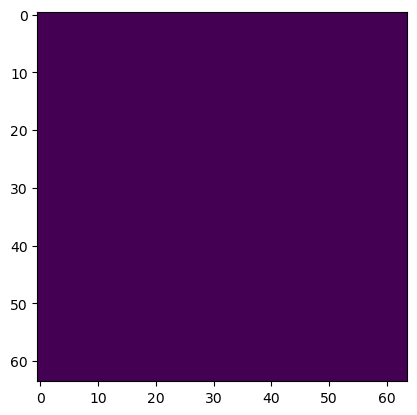

In [22]:
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
plt.imshow(pressure[0])
plt.show()

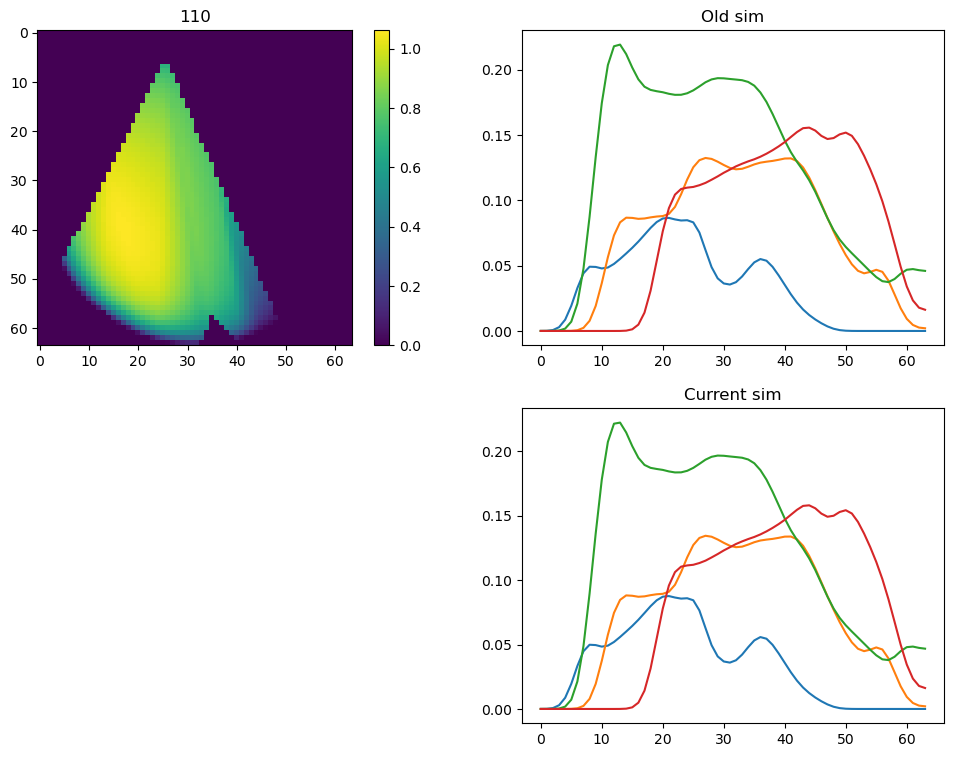

In [23]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 2, 4)
    plt.plot(sim.fiber_real_sim(pressure[i])[0].T)
    plt.title("Current sim")
    plt.show()
    time.sleep(0.5)

With model run comparison

In [24]:

if not torch.cuda.is_available():
    print('CUDA is NOT available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# %%
tr = config['video_train']

CUDA is NOT available.  Training on CPU ...


In [25]:

signal_shape, pressure_shape = (1, 4, 64), (64, 64)
print('input chain shape: ', signal_shape, '\noutput chain shape: ',
      pressure_shape)

model_name = tr['model_name']
from video_pipeline import models_src

model_class = eval(f"models_src.{model_name}")

args = []
if model_name.startswith("Param"):
    layers = tr['layers']
    args.append(layers)
args.append(frames_number)
args.append(frames_interval)
model = model_class(pressure_shape[-2:], signal_shape[-2:], *args)
model = model.to(device)

print(model)

input chain shape:  (1, 4, 64) 
output chain shape:  (64, 64)
ParamUnet(
  (step1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
  )
  (finalConv): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  )
  (bottom): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
    (1): Sequential(
   

In [26]:
# loading data
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
# plt.imshow(pressure[0])
# plt.show()

In [27]:
checkpoint = torch.load("data/365_id_model.pt",
                     map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval();

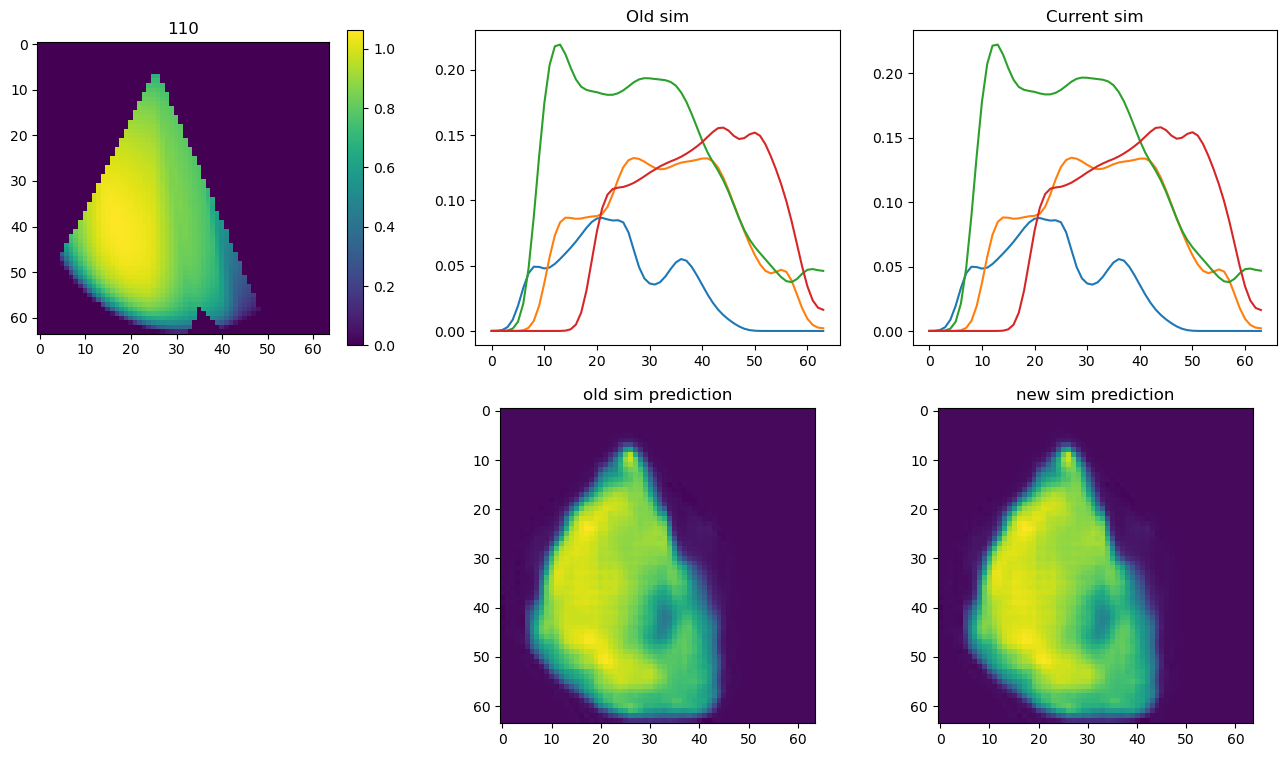

In [28]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

### Начало рабочей области

#### Сравнение кривых.

In [8]:
point_pres = torch.zeros((64, 64))
point_pres[31, 31] = 1

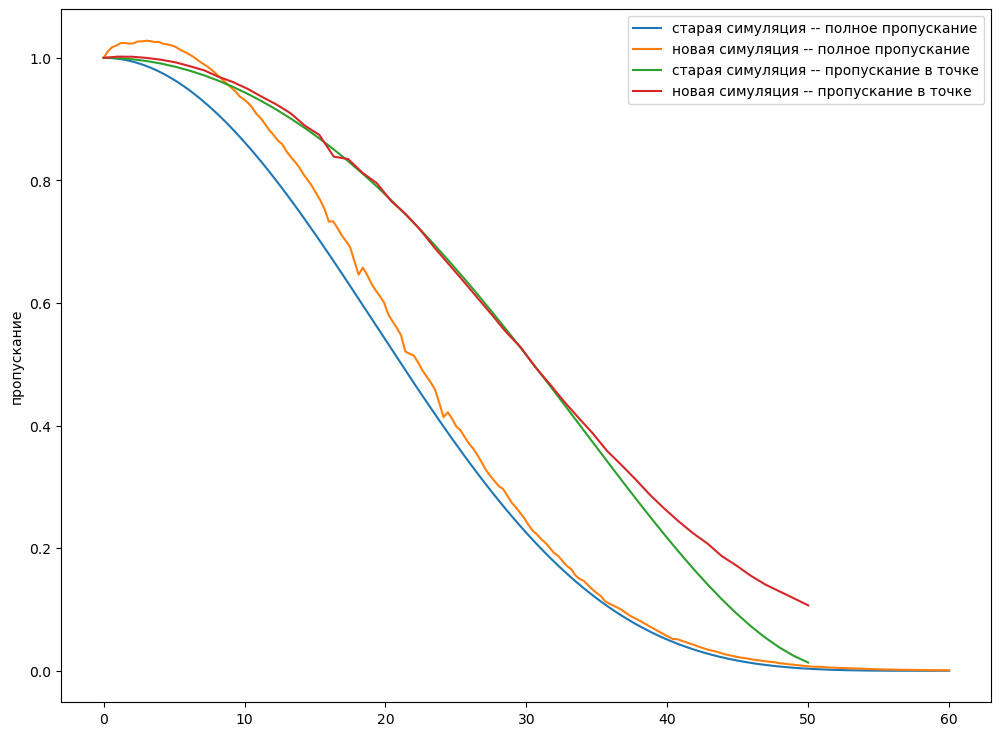

In [15]:
plt.figure(figsize=(12, 9))
plt.ylabel("пропускание")

x = np.linspace(0, 60, 200)
y = []
for alpha in x:
    new_signal = sim.fiber_real_sim(point_pres*alpha)
    y.append(new_signal[0][0][31])
y = np.array(y)
plt.plot(x, 1-y, label='старая симуляция -- полное пропускание')

x = np.linspace(0, 60, 200)
y = []
for alpha in x:
    new_signal = new_sim.fiber_real_sim(point_pres*alpha)
    y.append(new_signal[0][0][31])
y = np.array(y)
plt.plot(x, 1-y, label='новая симуляция -- полное пропускание')

x2 = torch.from_numpy(np.linspace(0, 2.5))
y2 = sim._trans_fun(x2)
plt.plot(x2*50/2.5, y2, label='старая симуляция -- пропускание в точке')


x3 = torch.from_numpy(np.linspace(0, 2.5))
loss_coef = new_sim._loss_coeff_function(x3)
y3 = np.exp(-(loss_coef*0.35))
plt.plot(x3*50/2.5, y3, label='новая симуляция -- пропускание в точке')


plt.legend()


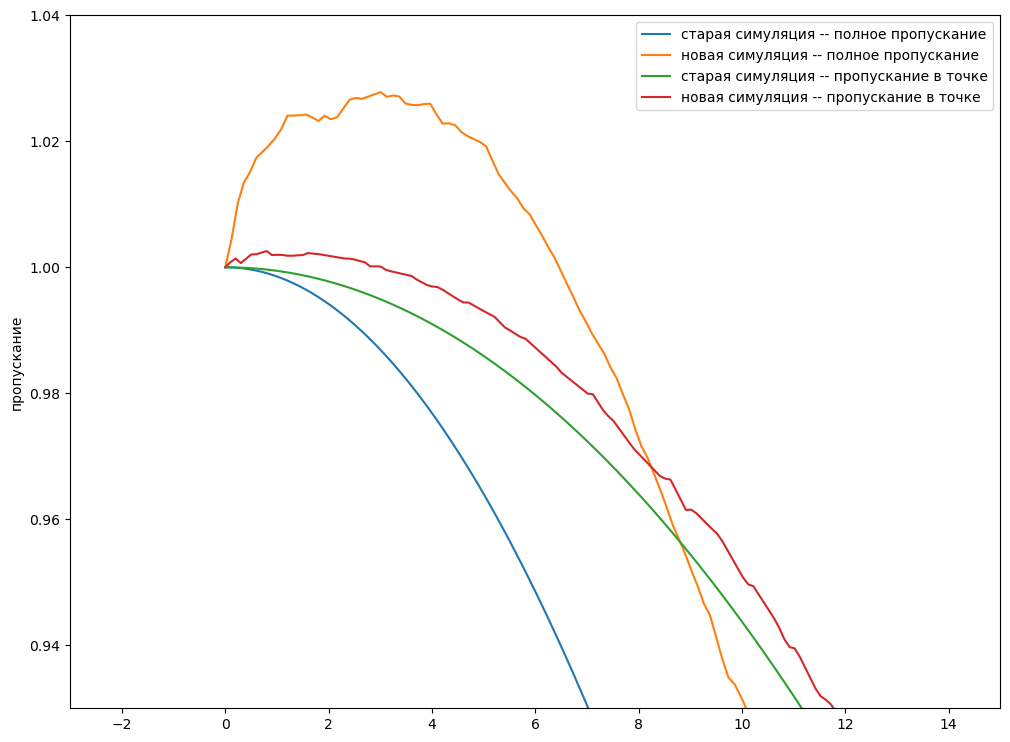

In [16]:
plt.figure(figsize=(12, 9))
plt.ylabel("пропускание")

x = np.linspace(0, 60, 500)
y = []
for alpha in x:
    new_signal = sim.fiber_real_sim(point_pres*alpha)
    y.append(new_signal[0][0][31])
y = np.array(y)
plt.plot(x, 1-y, label='старая симуляция -- полное пропускание')

x = np.linspace(0, 60, 500)
y = []
for alpha in x:
    new_signal = new_sim.fiber_real_sim(point_pres*alpha)
    y.append(new_signal[0][0][31])
y = np.array(y)
plt.plot(x, 1-y, label='новая симуляция -- полное пропускание')

x2 = torch.from_numpy(np.linspace(0, 2.5, 500))
y2 = sim._trans_fun(x2)
plt.plot(x2*50/2.5, y2, label='старая симуляция -- пропускание в точке')


x3 = torch.from_numpy(np.linspace(0, 2.5, 500))
loss_coef = new_sim._loss_coeff_function(x3)
y3 = np.exp(-(loss_coef*0.35))
plt.plot(x3*50/2.5, y3, label='новая симуляция -- пропускание в точке')


plt.legend()

plt.ylim(0.93, 1.04)
plt.xlim(right=15)


#### Меняю размер сетки.

In [24]:

import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

with open('params.yaml') as conf_file:
    x2config = yaml.safe_load(conf_file)
x2config['env']['sen_geometry']['distance'] =  0.35/2

x2sim = tsl.FiberSimulator(x2config)


In [20]:
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
# plt.imshow(pressure[0])
# plt.show()

(300, 128, 128)


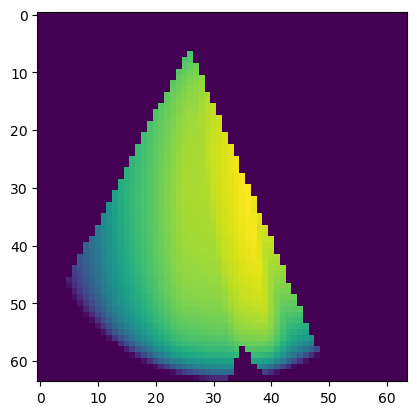

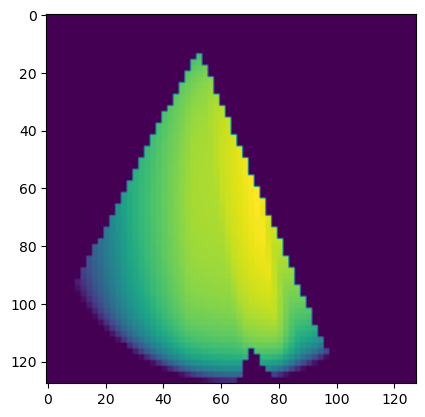

In [21]:
new_pressure = np.repeat(np.repeat(pressure, 2, axis=-2), 2, axis=-1)
print(new_pressure.shape)

plt.imshow(pressure[120])
plt.show()
plt.imshow(new_pressure[120])
plt.show()

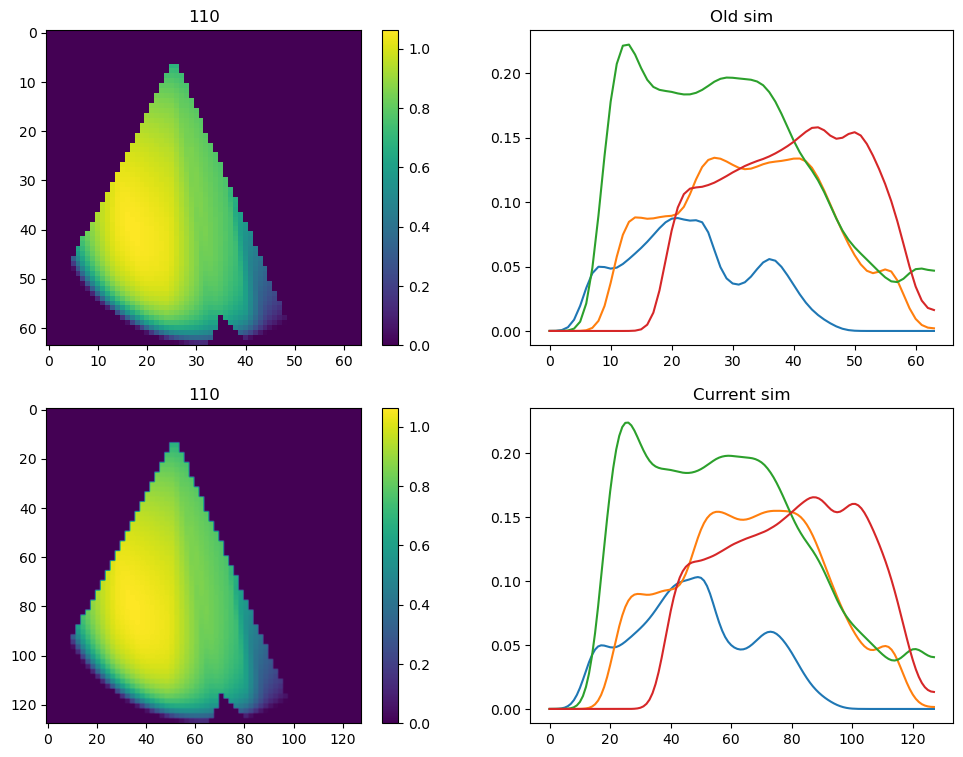

In [28]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 2, 3)
    plt.imshow(new_pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    
    
    plt.subplot(2, 2, 2)
    signals1 = sim.fiber_real_sim(pressure[i])[0]
    plt.plot(signals1.T)
    # plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 2, 4)
    signals2 = x2sim.fiber_real_sim(new_pressure[i])[0]
    plt.plot(signals2.T)
    plt.title("Current sim")
    plt.show()
    time.sleep(0.5)

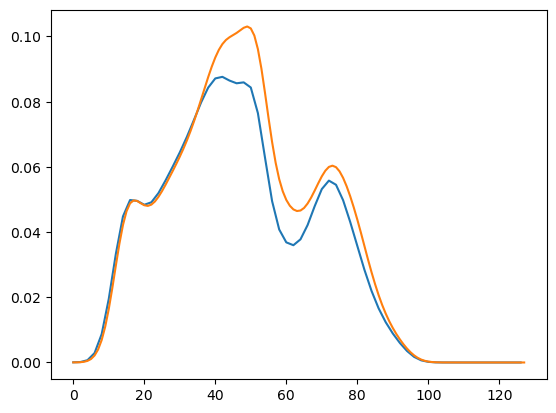

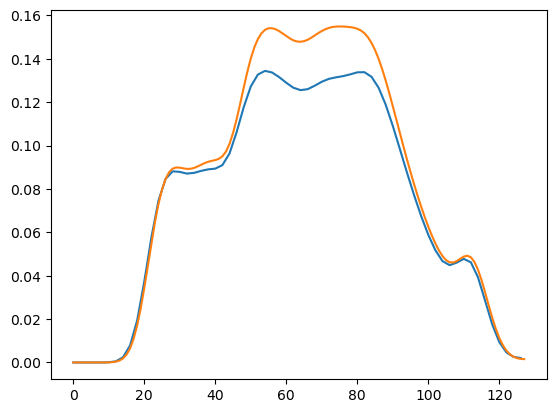

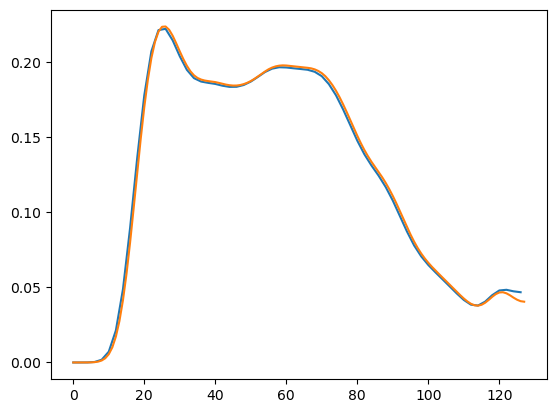

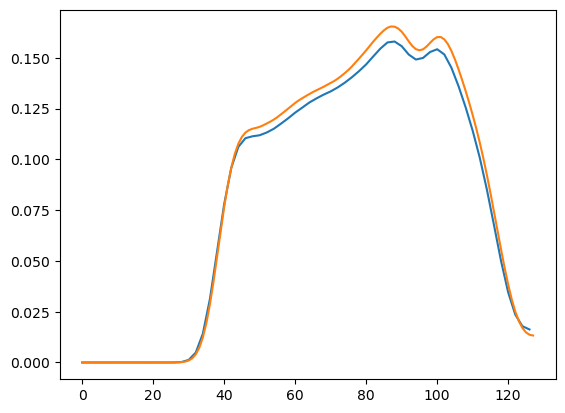

In [31]:
for i in range(len(signals1)):
    plt.plot(range(0, len(signals2[i]), 2), signals1[i])
    plt.plot(signals2[i])
    plt.show()
    

А теперь в 10 раз увеличим

In [32]:
k = 10

In [41]:

import torch_sensor_lib as tsl
config['sim']['test_mod'] = True
sim1 = tsl.FiberSimulator(config)
config['sim']['test_mod'] = False

with open('params.yaml') as conf_file:
    xconfig = yaml.safe_load(conf_file)
xconfig['env']['sen_geometry']['distance'] =  0.35/k
xconfig['sim']['test_mod'] = True
xsim = tsl.FiberSimulator(xconfig)


In [39]:
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
new_pressure = np.repeat(np.repeat(pressure, k, axis=-2), k, axis=-1)
print(new_pressure.shape)

# plt.imshow(pressure[120])
# plt.show()
# plt.imshow(new_pressure[120])
# plt.show()

(300, 640, 640)


Rot tensors


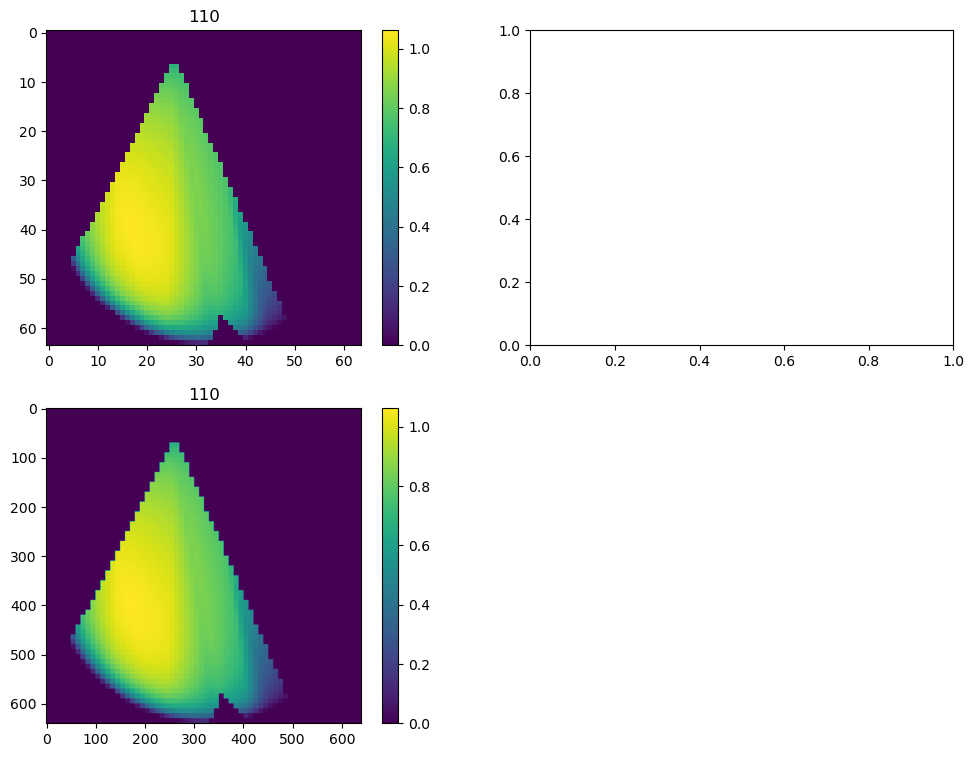

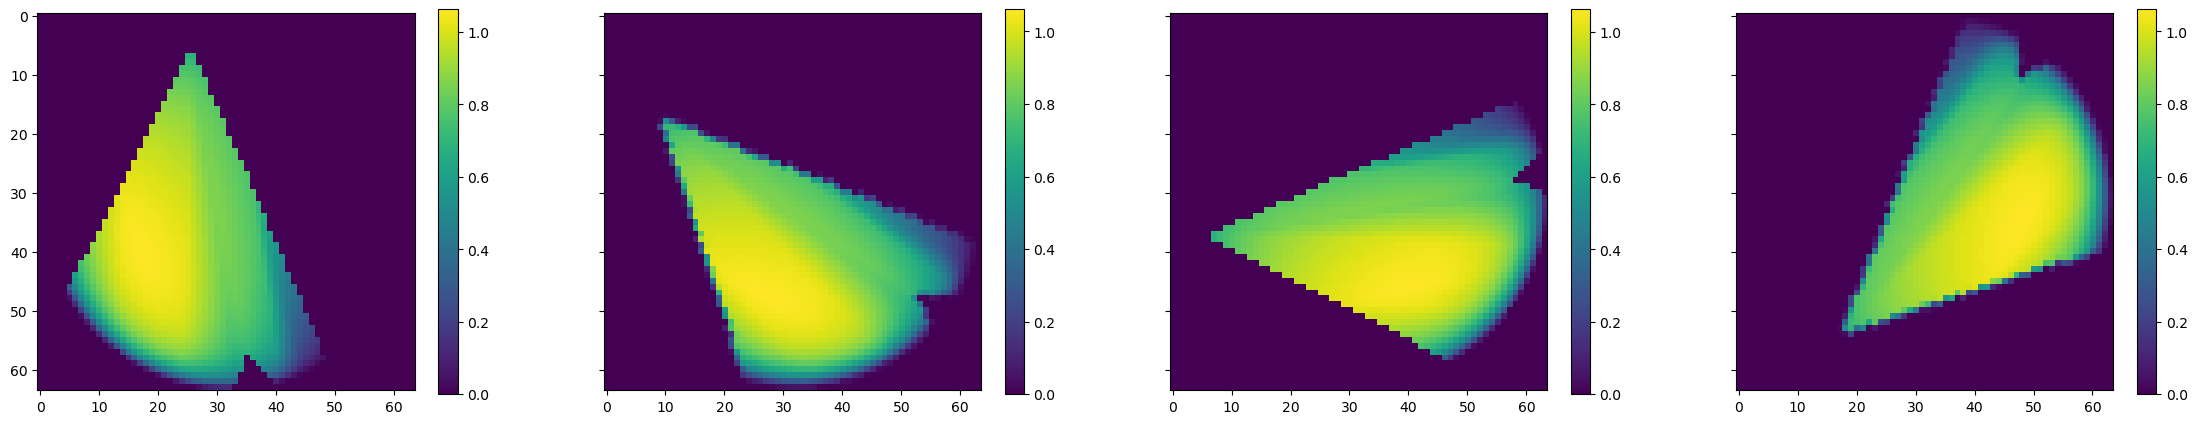

After blur


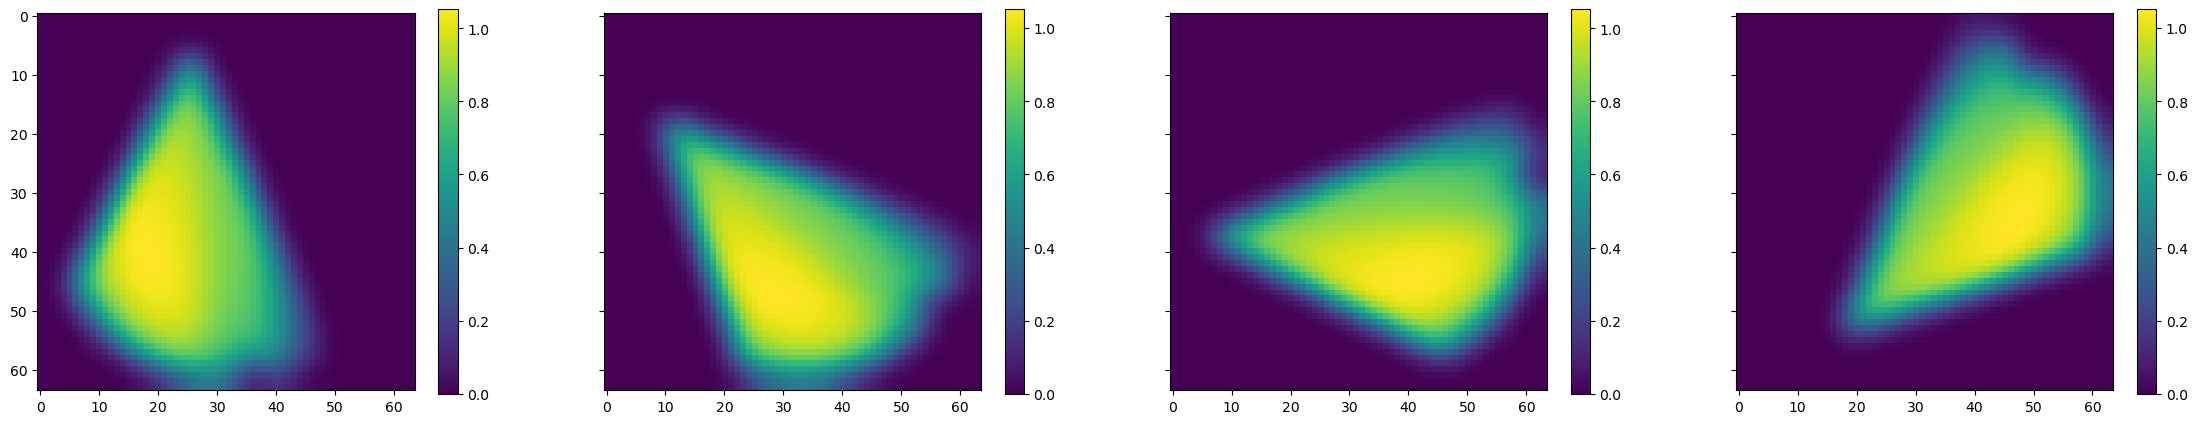

Loss in fiber


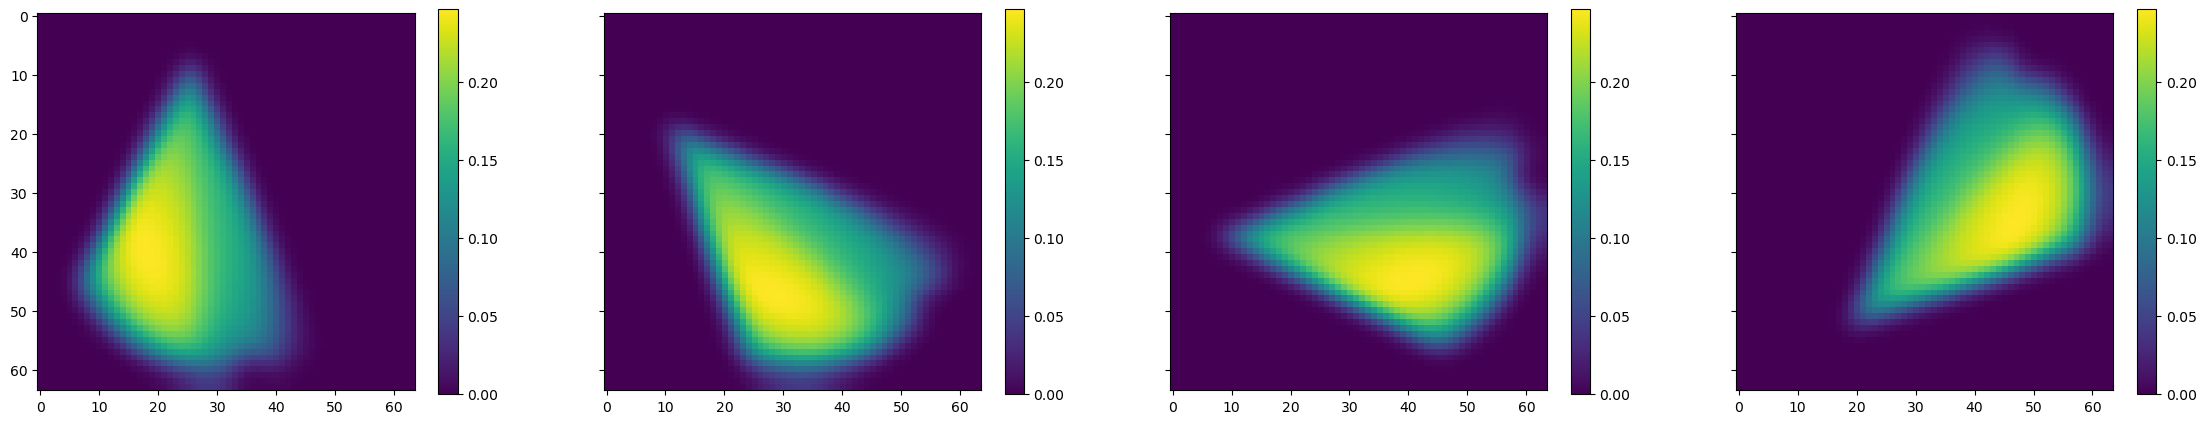

Loss sums


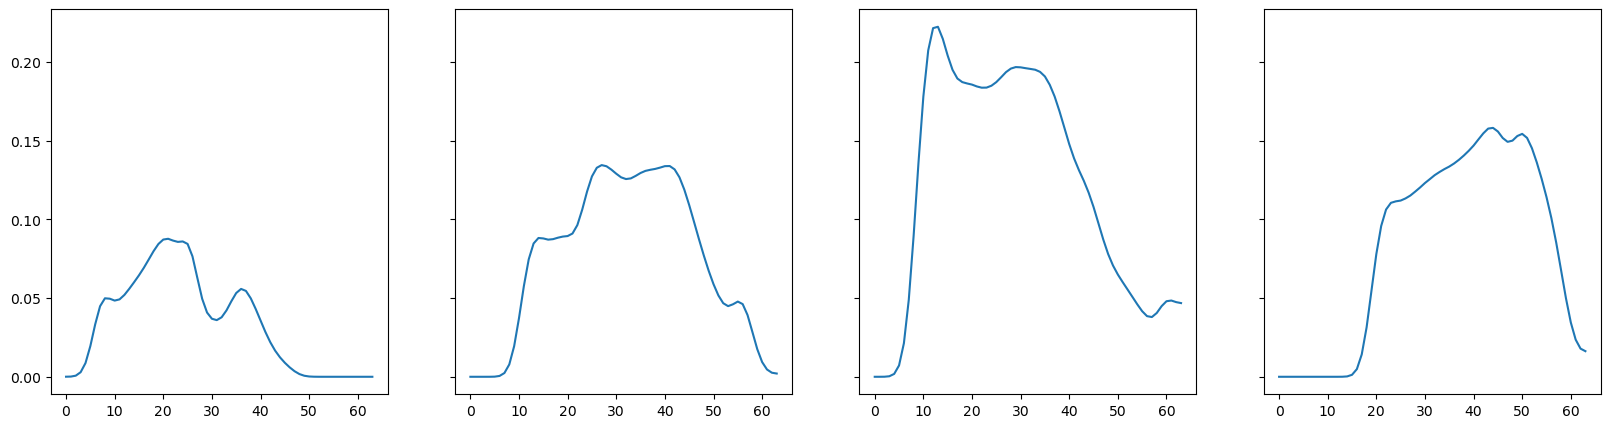

Signal


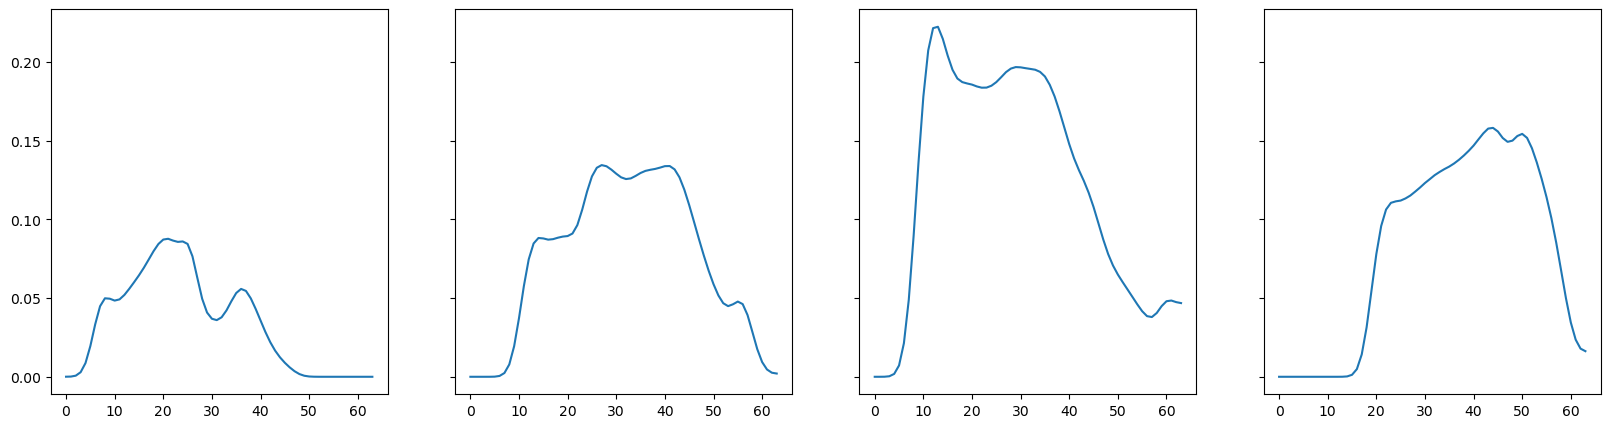

Rot tensors


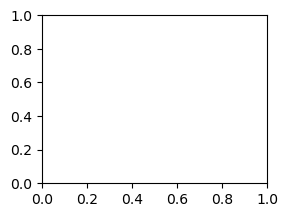

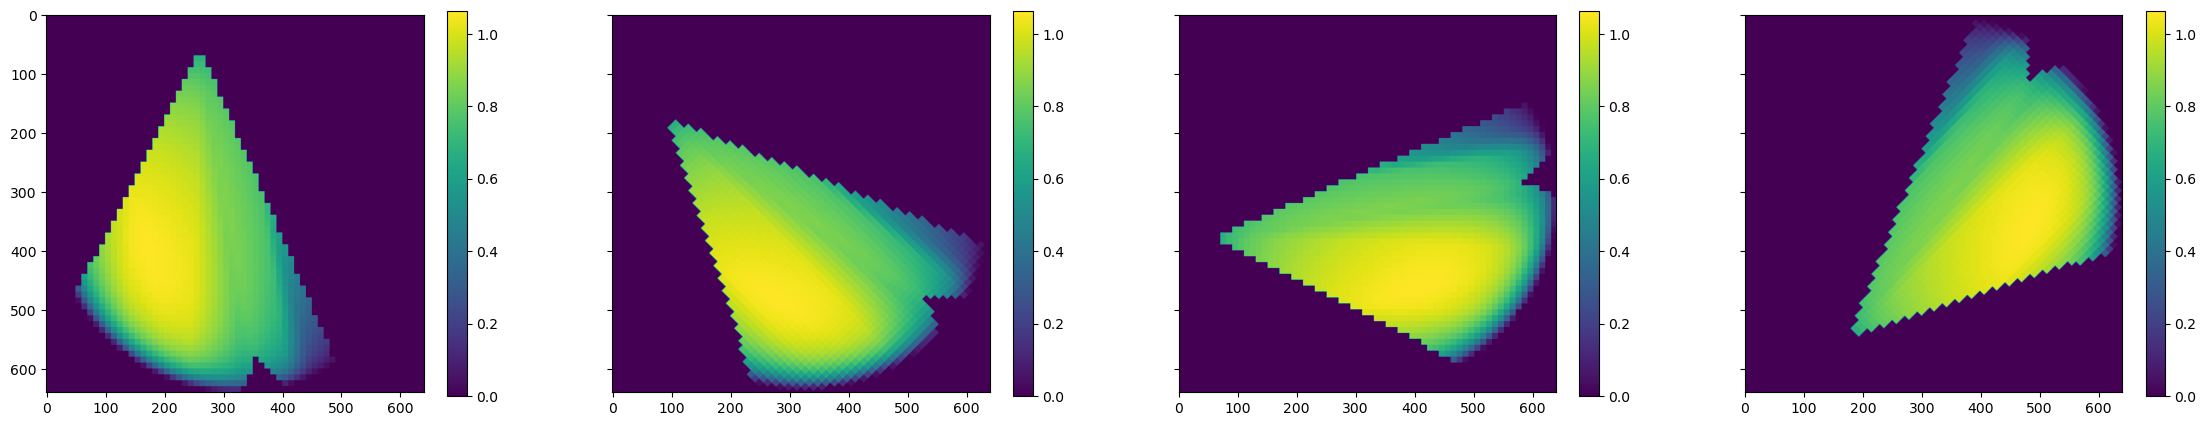

After blur


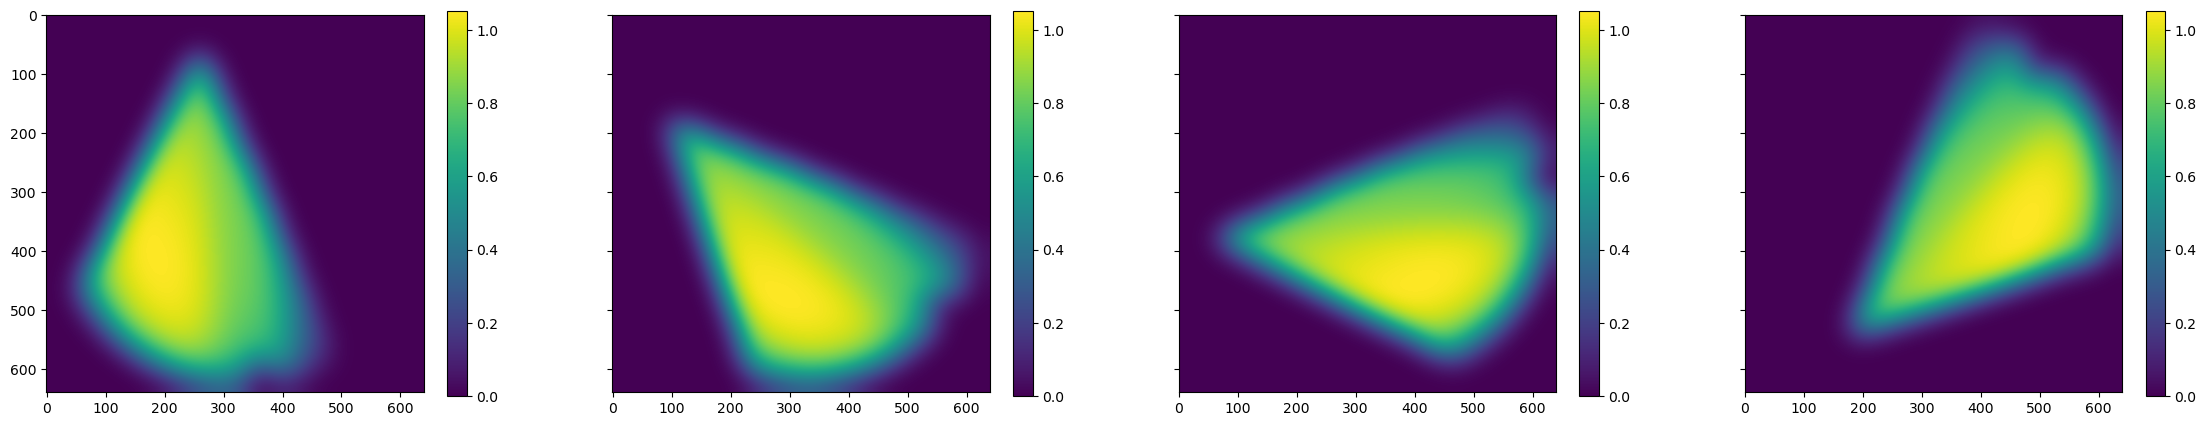

Loss in fiber


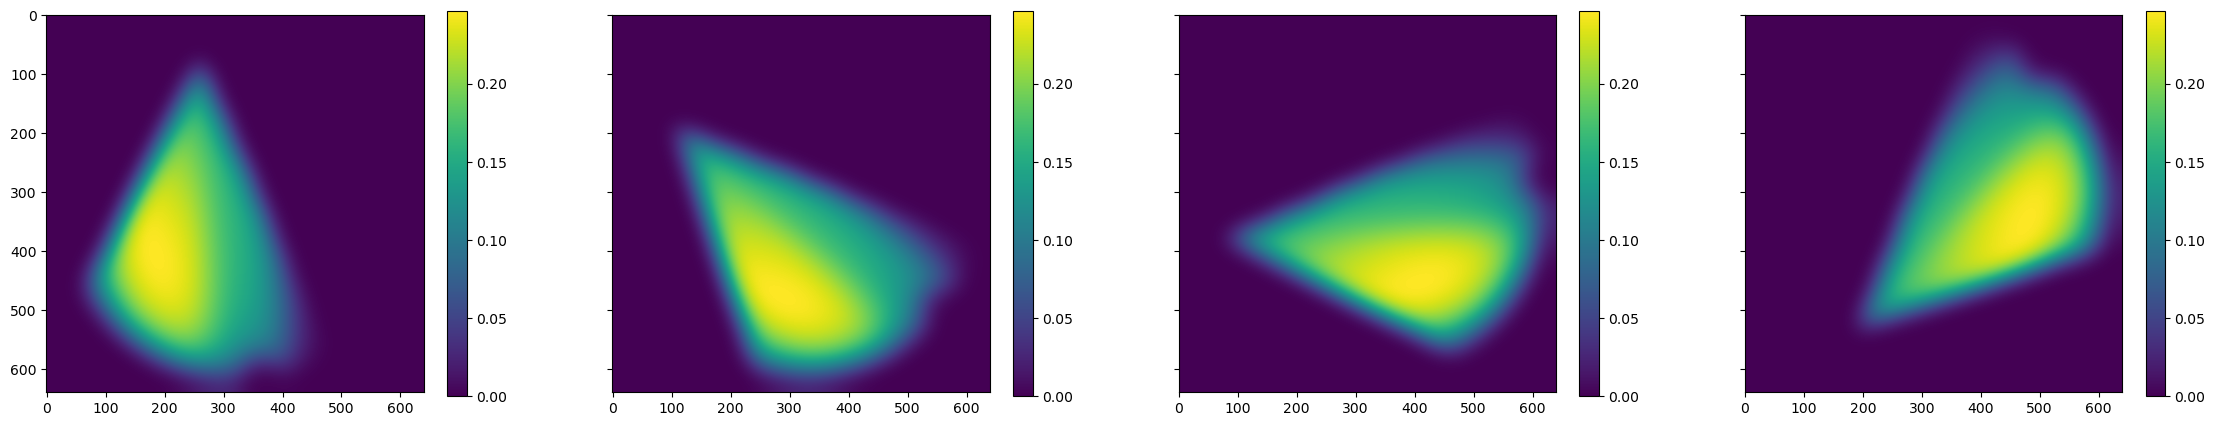

Loss sums


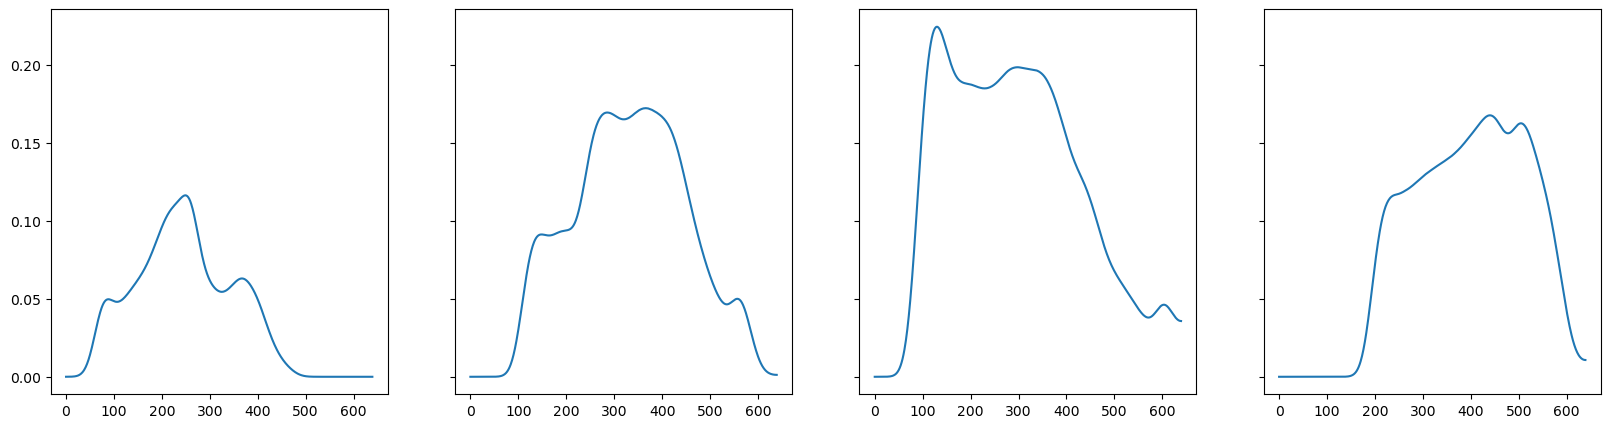

Signal


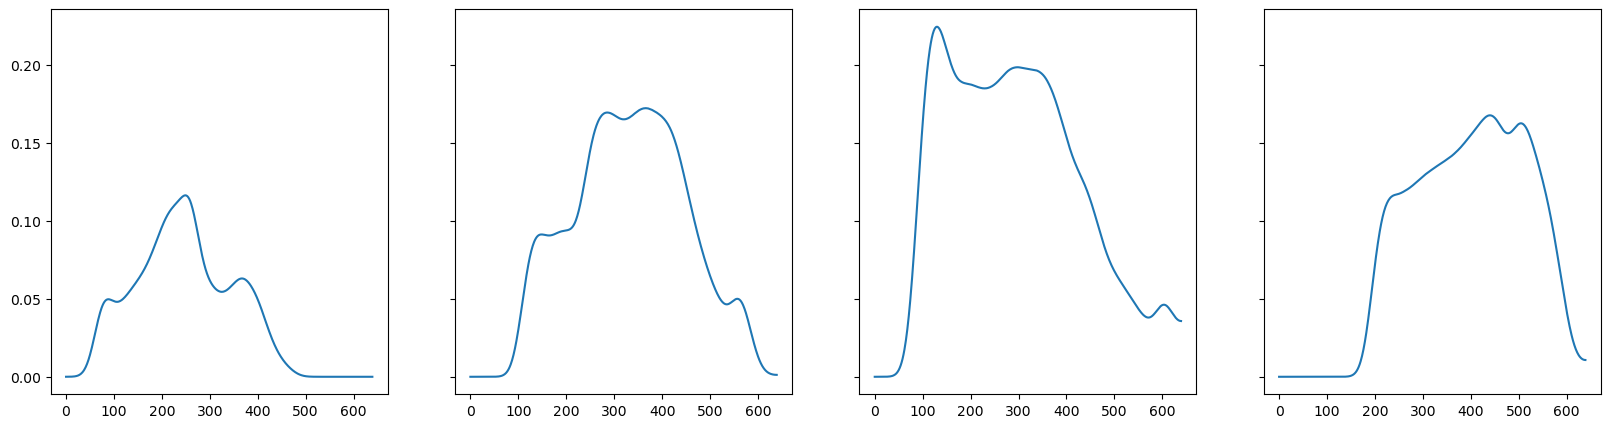

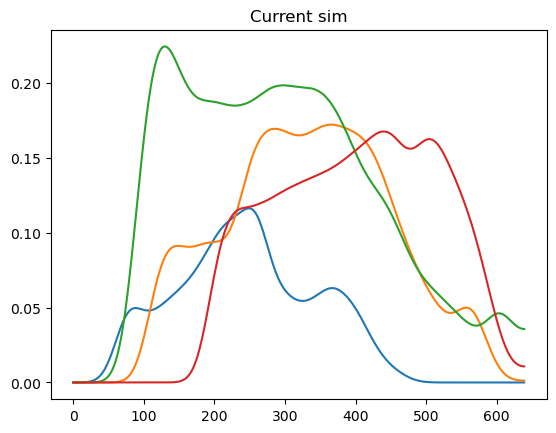

In [42]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 2, 3)
    plt.imshow(new_pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    
    
    plt.subplot(2, 2, 2)
    signals1 = sim1.fiber_real_sim(pressure[i])[0]
    plt.plot(signals1.T)
    # plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 2, 4)
    signals2 = xsim.fiber_real_sim(new_pressure[i])[0]
    plt.plot(signals2.T)
    plt.title("Current sim")
    plt.show()
    time.sleep(0.5)

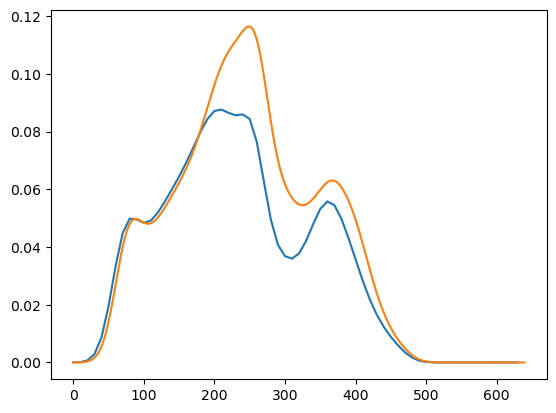

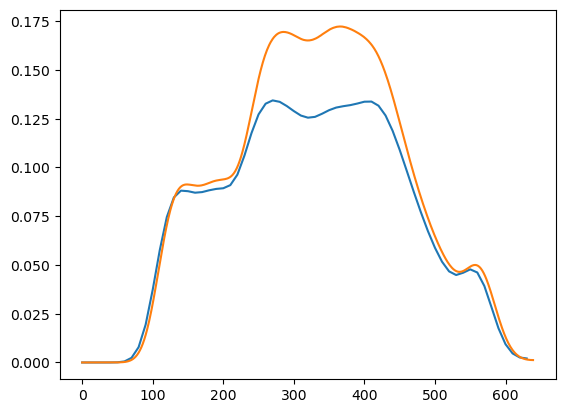

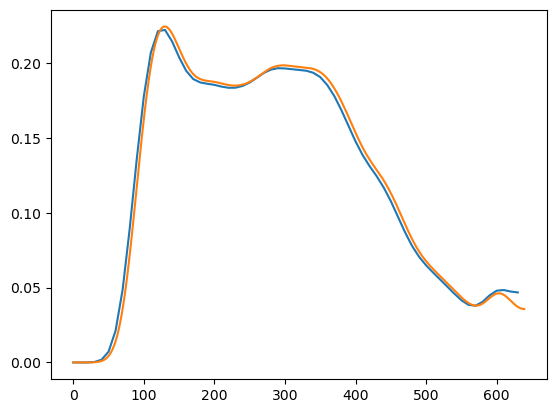

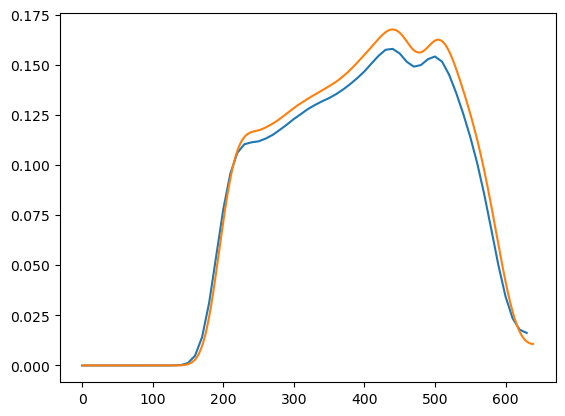

In [37]:
for i in range(len(signals1)):
    plt.plot(range(0, len(signals2[i]), k), signals1[i])
    plt.plot(signals2[i])
    plt.show()
    

В общем видно, что с какой-то точностью оно не меняется, но лучше использовать побольше разрешение, хотя бы в два раза, чтобы резкие перепады правильно обрабатывались.

### Строю профили чувствительности.

Для этого нужно маленький кусочек крупно рассмотреть. Примерно 4 мм, 64 точки. То есть расстояние между волокнами -- 1/16 мм. А лучше 256 точек, тогда 4/256

In [43]:
l = 4   # длина в мм
N = 256 # количество точек
fiber_dist = k/N

In [47]:
import torch_sensor_lib as tsl

with open('params.yaml') as conf_file:
    xconfig = yaml.safe_load(conf_file)
xconfig['env']['sen_geometry']['distance'] =  fiber_dist
xsim = tsl.FiberSimulator(xconfig)

In [45]:
point_pres = torch.zeros((N, N))
point_pres[N//2, N//2] = 1

Rot tensors


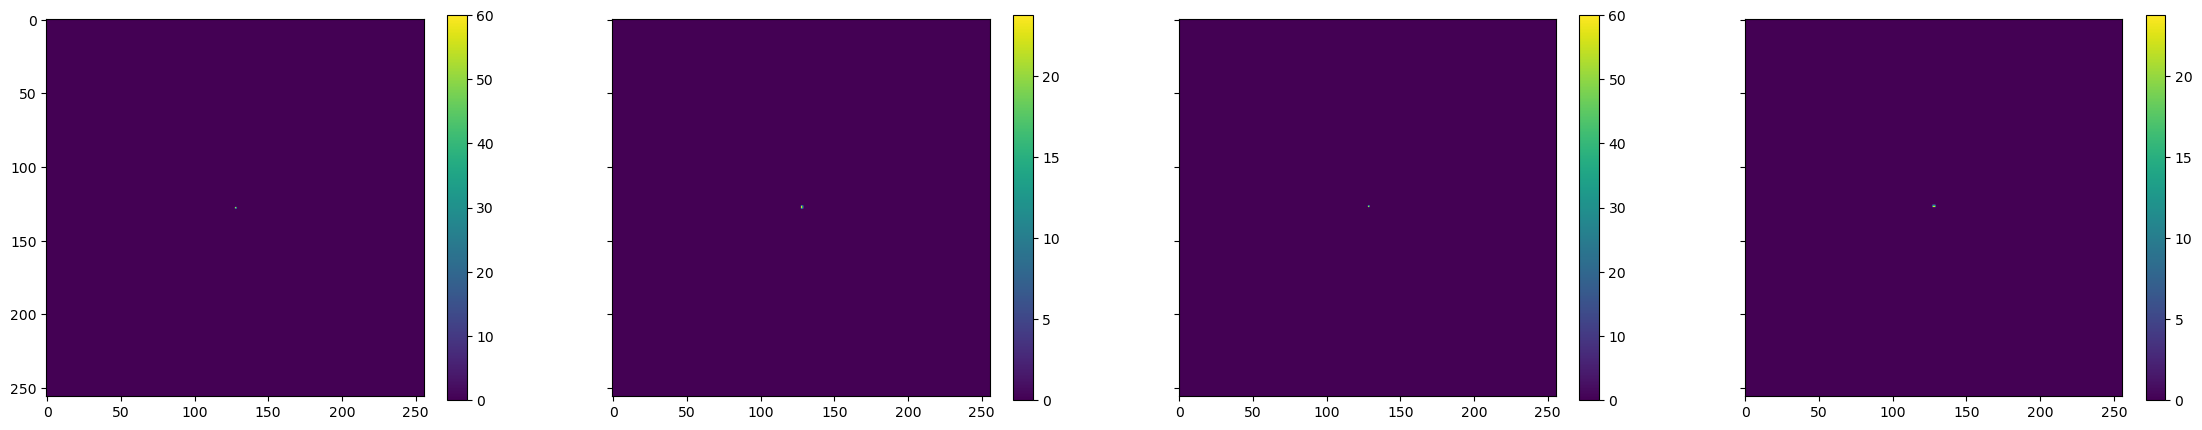

After blur


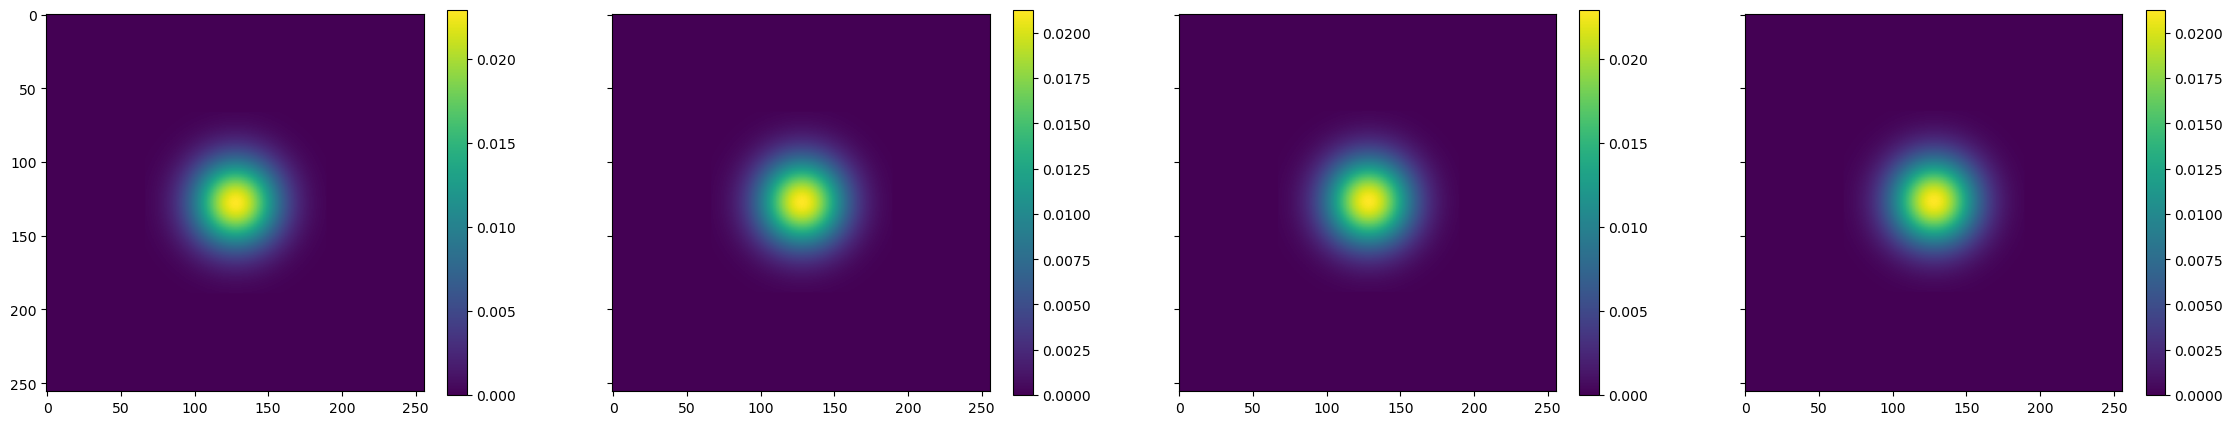

Loss in fiber


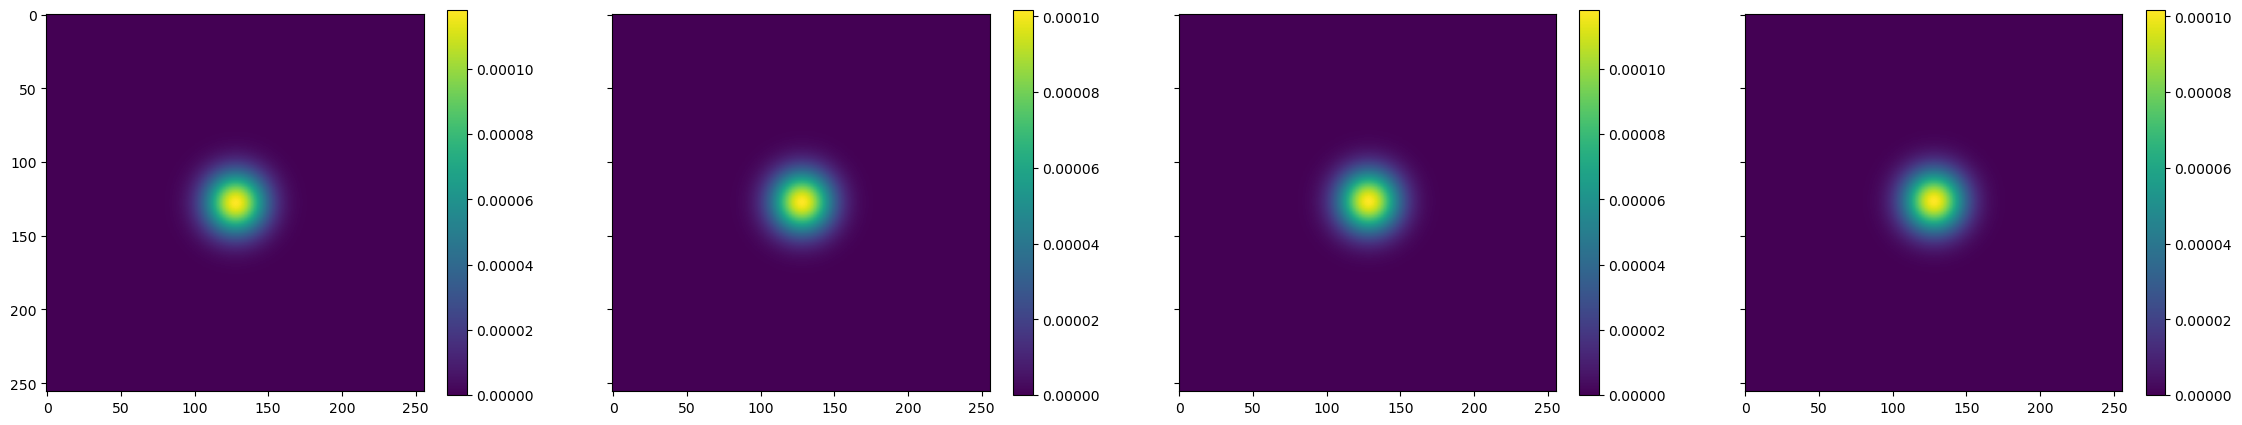

Loss sums


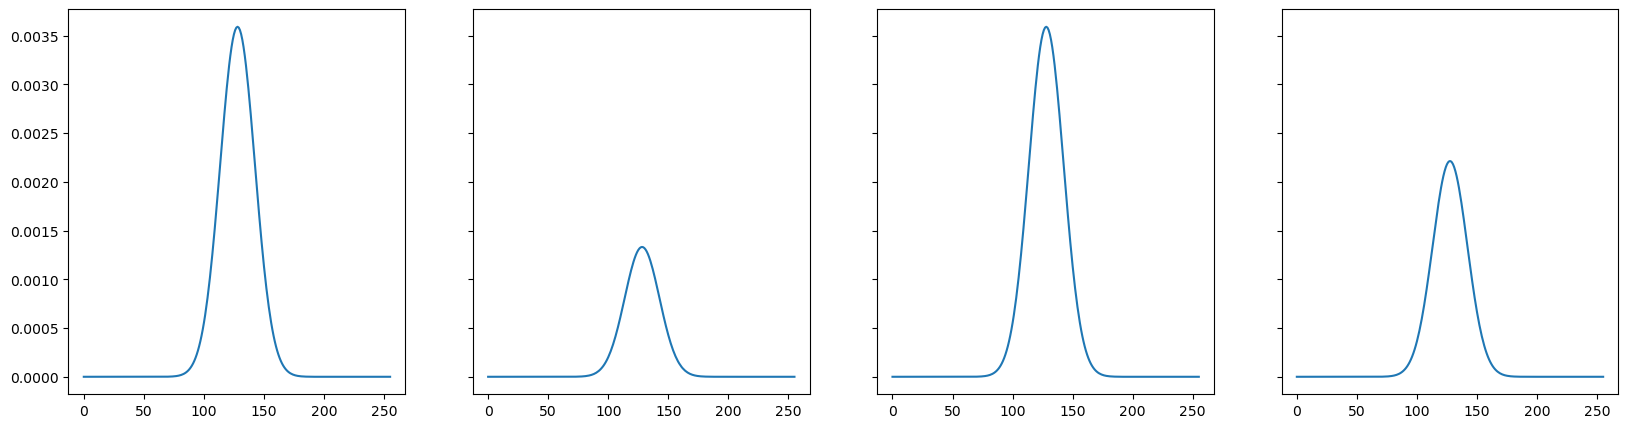

Signal


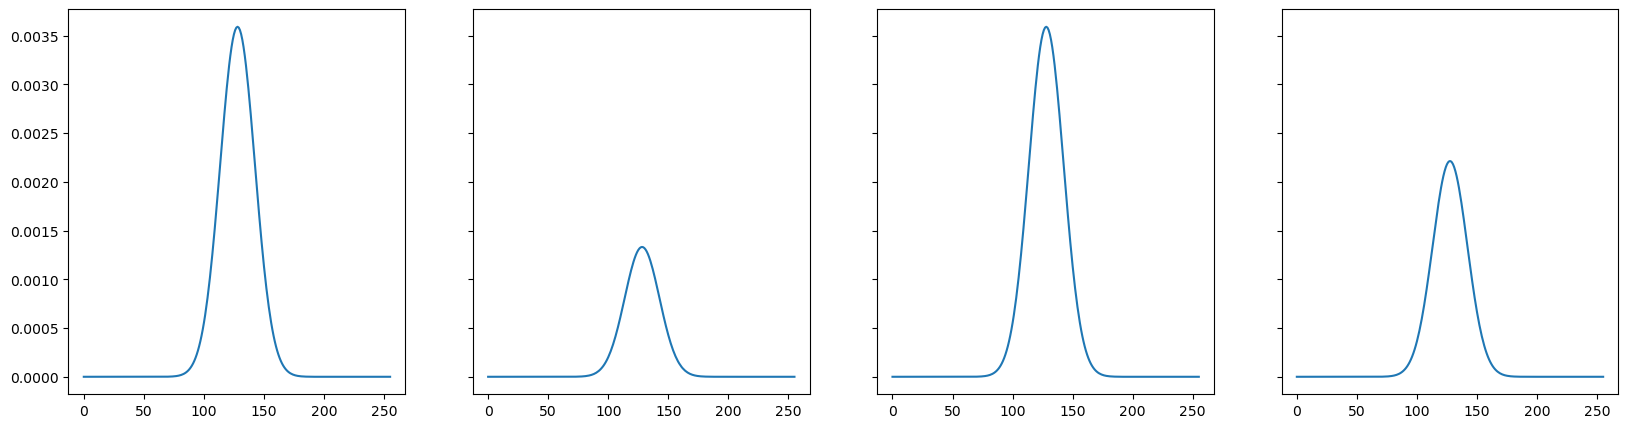

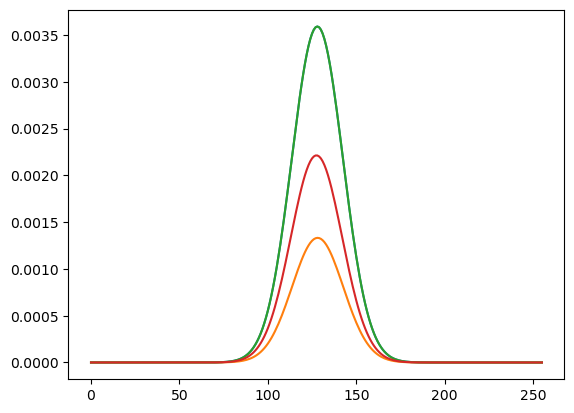

In [49]:
# amps = np.linspace(0, 60, 200)
amps = np.linspace(0, 60, 20)
amps = np.linspace(60, 60, 1)
result_array = np.zeros((len(amps), N))
xsim.test = True
for amplitude in amps:
    signal = xsim.fiber_real_sim(point_pres*amplitude)[0]
    plt.plot(signal.T)
xsim.test = False

Очень интересно, почему это у меня при поворотах гауссового пятна получается такие разные штуки........

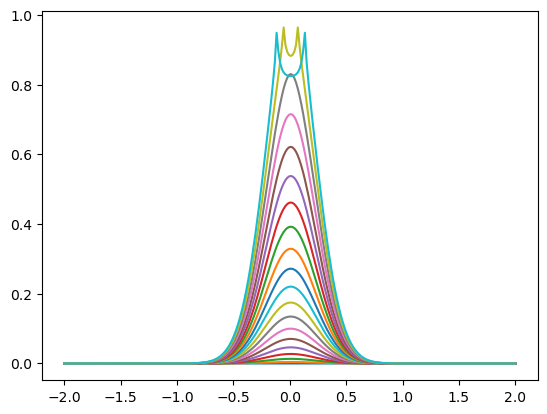

In [55]:
# amps = np.linspace(0, 60, 200)
amps = np.linspace(0, 60, 20)
amps = np.linspace(1, 60, 20)*(N/64)**2
result_array = np.zeros((len(amps), N))
xsim.test = False
for i, amplitude in enumerate(amps):
    signal = xsim.fiber_real_sim(point_pres*amplitude)[0]
    result_array[i] = signal[0]
plt.plot(np.linspace(-l/2, l/2, N), result_array.T);

In [54]:
# np.save("simToReal/simed_sensing_profiles.npy", result_array)